# Reshaping & Tidy Data

> Structuring datasets to facilitate analysis [(Wickham 2014)](http://www.jstatsoft.org/v59/i10/paper)

So, you've sat down to analyze a new dataset.
What do you do first?

In episode 11 of [Not So Standard Deviations](https://www.patreon.com/NSSDeviations?ty=h), Hilary and Roger discussed their typical approaches.
I'm with Hilary on this one, you should make sure your data is tidy.
Before you do any plots, filtering, transformations, summary statistics, regressions...
Without a tidy dataset, you'll be fighting your tools to get the result you need.
With a tidy dataset, it's relatively easy to do all of those.

Hadley Wickham kindly summarized tidiness as a dataset where

1. Each variable forms a column
2. Each observation forms a row
3. Each type of observational unit forms a table

And today we'll only concern ourselves with the first two.
As quoted at the top, this really is about facilitating analysis: going as quickly as possible from question to answer.

In [2]:
%matplotlib inline

import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import lxml as lxml

if int(os.environ.get("MODERN_PANDAS_EPUB", 0)):
    import prep # noqa

pd.options.display.max_rows = 10
sns.set(style='ticks', context='talk')

## NBA Data

[This](http://stackoverflow.com/questions/22695680/python-pandas-timedelta-specific-rows) StackOverflow question asked about calculating the number of days of rest NBA teams have between games.
The answer would have been difficult to compute with the raw data.
After transforming the dataset to be tidy, we're able to quickly get the answer.

We'll grab some NBA game data from basketball-reference.com using pandas' `read_html` function, which returns a list of DataFrames.

In [12]:
fp = 'data/nba.csv'

if not os.path.exists(fp):
    tables = pd.read_html("http://www.basketball-reference.com/leagues/NBA_2016_games.html")
    games = tables[0]
    games.to_csv(fp)
else:
    games = pd.read_csv(fp)
games.head()

,Unnamed: 0,Date,Start (ET),Visitor/Neutral,PTS,Home/Neutral,PTS.1,Unnamed: 6,Unnamed: 7,Attend.,Notes
0,0,"Tue, Oct 27, 2015",8:00p,Cleveland Cavaliers,95,Chicago Bulls,97,Box Score,NaN,21957,NaN
1,1,"Tue, Oct 27, 2015",8:00p,Detroit Pistons,106,Atlanta Hawks,94,Box Score,NaN,19187,NaN
2,2,"Tue, Oct 27, 2015",10:30p,New Orleans Pelicans,95,Golden State Warriors,111,Box Score,NaN,19596,NaN
3,3,"Wed, Oct 28, 2015",7:00p,Washington Wizards,88,Orlando Magic,87,Box Score,NaN,18846,NaN
4,4,"Wed, Oct 28, 2015",7:30p,Philadelphia 76ers,95,Boston Celtics,112,Box Score,NaN,18624,NaN


Side note: pandas' `read_html` is pretty good. On simple websites it almost always works.
It provides a couple parameters for controlling what gets selected from the webpage if the defaults fail.
I'll always use it first, before moving on to [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/) or [lxml](http://lxml.de/) if the page is more complicated.

As you can see, we have a bit of general munging to do before tidying.
Each month slips in an extra row of mostly NaNs, the column names aren't too useful, and we have some dtypes to fix up.

In [14]:
column_names = {'Date': 'date', 'Start (ET)': 'start',
                'Unamed: 2': 'box', 'Visitor/Neutral': 'away_team', 
                'PTS': 'away_points', 'Home/Neutral': 'home_team',
                'PTS.1': 'home_points', 'Unamed: 7': 'n_ot'}

games = (games.rename(columns=column_names)
    .dropna(thresh=4)
    [['date', 'away_team', 'away_points', 'home_team', 'home_points']]
    .assign(date=lambda x: pd.to_datetime(x['date'], format='%a, %b %d, %Y'))
    .set_index('date', append=True) # keep original index, which represent a game
    .rename_axis(["game_id", "date"])
    .sort_index())
games.head()

,,away_team,away_points,home_team,home_points
game_id,date,,,,
0,2015-10-27,Cleveland Cavaliers,95,Chicago Bulls,97
1,2015-10-27,Detroit Pistons,106,Atlanta Hawks,94
2,2015-10-27,New Orleans Pelicans,95,Golden State Warriors,111
3,2015-10-28,Washington Wizards,88,Orlando Magic,87
4,2015-10-28,Philadelphia 76ers,95,Boston Celtics,112


A quick aside on that last block.

- `dropna` has a `thresh` argument. If at least `thresh` items are missing, the row is dropped. We used it to remove the "Month headers" that slipped into the table.
- `assign` can take a callable. This lets us refer to the DataFrame in the previous step of the chain. Otherwise we would have to assign `temp_df = games.dropna()...` And then do the `pd.to_datetime` on that.
- `set_index` has an `append` keyword. We keep the original index around since it will be our unique identifier per game.
- We use `.rename_axis` to set the index names (this behavior is new in pandas 0.18; before `.rename_axis` only took a mapping for changing labels).

The Question:
> **How many days of rest did each team get between each game?**

Whether or not your dataset is tidy depends on your question. Given our question, what is an observation?

In this case, an observation is a `(team, game)` pair, which we don't have yet. Rather, we have two observations per row, one for home and one for away. We'll fix that with `pd.melt`.

`pd.melt` works by taking observations that are spread across columns (`away_team`, `home_team`), and melting them down into one column with multiple rows. However, we don't want to lose the metadata (like `game_id` and `date`) that is shared between the observations. By including those columns as `id_vars`, the values will be repeated as many times as needed to stay with their observations.

In [15]:
games

,,away_team,away_points,home_team,home_points
game_id,date,,,,
0,2015-10-27,Cleveland Cavaliers,95,Chicago Bulls,97
1,2015-10-27,Detroit Pistons,106,Atlanta Hawks,94
2,2015-10-27,New Orleans Pelicans,95,Golden State Warriors,111
3,2015-10-28,Washington Wizards,88,Orlando Magic,87
4,2015-10-28,Philadelphia 76ers,95,Boston Celtics,112
...,...,...,...,...,...
33,2015-10-31,New York Knicks,117,Washington Wizards,110
34,2015-10-31,Golden State Warriors,134,New Orleans Pelicans,120
35,2015-10-31,Brooklyn Nets,91,Memphis Grizzlies,101


In [16]:
# my take
pd.melt(games.reset_index(), id_vars=['game_id', 'date'], value_vars=['away_team', 'home_team'], var_name='team')

,game_id,date,team,value
0,0,2015-10-27,away_team,Cleveland Cavaliers
1,1,2015-10-27,away_team,Detroit Pistons
2,2,2015-10-27,away_team,New Orleans Pelicans
3,3,2015-10-28,away_team,Washington Wizards
4,4,2015-10-28,away_team,Philadelphia 76ers
...,...,...,...,...
71,33,2015-10-31,home_team,Washington Wizards
72,34,2015-10-31,home_team,New Orleans Pelicans
73,35,2015-10-31,home_team,Memphis Grizzlies
74,36,2015-10-31,home_team,Portland Trail Blazers


In [17]:
tidy = pd.melt(games.reset_index(),
               id_vars=['game_id', 'date'], value_vars=['away_team', 'home_team'],
               value_name='team')
tidy.head()

,game_id,date,variable,team
0,0,2015-10-27,away_team,Cleveland Cavaliers
1,1,2015-10-27,away_team,Detroit Pistons
2,2,2015-10-27,away_team,New Orleans Pelicans
3,3,2015-10-28,away_team,Washington Wizards
4,4,2015-10-28,away_team,Philadelphia 76ers


The DataFrame `tidy` meets our rules for tidiness: each variable is in a column, and each observation (`team`, `date` pair) is on its own row.
Now the translation from question ("How many days of rest between games") to operation ("date of today's game - date of previous game - 1") is direct:

In [20]:
# For each team... get number of days between games
tidy.groupby('team')['date'].diff().dt.days - 1

0     NaN
1     NaN
2     NaN
3     NaN
4     NaN
     ... 
71    0.0
72    2.0
73    2.0
74    2.0
75    1.0
Name: date, Length: 76, dtype: float64

That's the essence of tidy data, the reason why it's worth considering what shape your data should be in.
It's about setting yourself up for success so that the answers naturally flow from the data (just kidding, it's usually still difficult. But hopefully less so).

Let's assign that back into our DataFrame

In [30]:
?tidy.date.diff

Signature: tidy.date.diff(periods=1)
Docstring:
First discrete difference of element.

Calculates the difference of a Series element compared with another
element in the Series (default is element in previous row).

Parameters
----------
periods : int, default 1
    Periods to shift for calculating difference, accepts negative
    values.

Returns
-------
Series
    First differences of the Series.

See Also
--------
Series.pct_change: Percent change over given number of periods.
Series.shift: Shift index by desired number of periods with an
    optional time freq.
DataFrame.diff: First discrete difference of object.

Notes
-----
For boolean dtypes, this uses :meth:`operator.xor` rather than
:meth:`operator.sub`.

Examples
--------
Difference with previous row

>>> s = pd.Series([1, 1, 2, 3, 5, 8])
>>> s.diff()
0    NaN
1    0.0
2    1.0
3    1.0
4    2.0
5    3.0
dtype: float64

Difference with 3rd previous row

>>> s.diff(periods=3)
0    NaN
1    NaN
2    NaN
3    2.0
4    4.0
5    6

In [34]:
tidy['rest'] = tidy.sort_values('date').groupby('team').date.diff().dt.days - 1
tidy.dropna().head()

,game_id,date,variable,team,rest
5,5,2015-10-28,away_team,Chicago Bulls,0.0
11,11,2015-10-28,away_team,Cleveland Cavaliers,0.0
14,14,2015-10-28,away_team,New Orleans Pelicans,0.0
17,17,2015-10-29,away_team,Memphis Grizzlies,0.0
18,18,2015-10-29,away_team,Atlanta Hawks,1.0


To show the inverse of `melt`, let's take `rest` values we just calculated and place them back in the original DataFrame with a `pivot_table`.

In [35]:
by_game = (pd.pivot_table(tidy, values='rest',
                          index=['game_id', 'date'],
                          columns='variable')
             .rename(columns={'away_team': 'away_rest',
                              'home_team': 'home_rest'}))
by_game

,variable,away_rest,home_rest
game_id,date,,
5,2015-10-28,0.0,NaN
6,2015-10-28,NaN,0.0
11,2015-10-28,0.0,NaN
14,2015-10-28,0.0,NaN
17,2015-10-29,0.0,0.0
...,...,...,...
33,2015-10-31,1.0,0.0
34,2015-10-31,0.0,2.0
35,2015-10-31,0.0,1.0


In [36]:
df = pd.concat([games, by_game], axis=1)
df.dropna().head()

,,away_team,away_points,home_team,home_points,away_rest,home_rest
game_id,date,,,,,,
17,2015-10-29,Memphis Grizzlies,112,Indiana Pacers,103,0.0,0.0
18,2015-10-29,Atlanta Hawks,112,New York Knicks,101,1.0,0.0
19,2015-10-29,Dallas Mavericks,88,Los Angeles Clippers,104,0.0,0.0
20,2015-10-30,Miami Heat,92,Cleveland Cavaliers,102,1.0,1.0
21,2015-10-30,Utah Jazz,99,Philadelphia 76ers,71,1.0,1.0


One somewhat subtle point: an "observation" depends on the question being asked.
So really, we have two tidy datasets, `tidy` for answering team-level questions, and `df` for answering game-level questions.

One potentially interesting question is "what was each team's average days of rest, at home and on the road?" With a tidy dataset (the DataFrame `tidy`, since it's team-level), `seaborn` makes this easy (more on seaborn in a future post):

In [37]:
sns.set(style='ticks', context='paper')

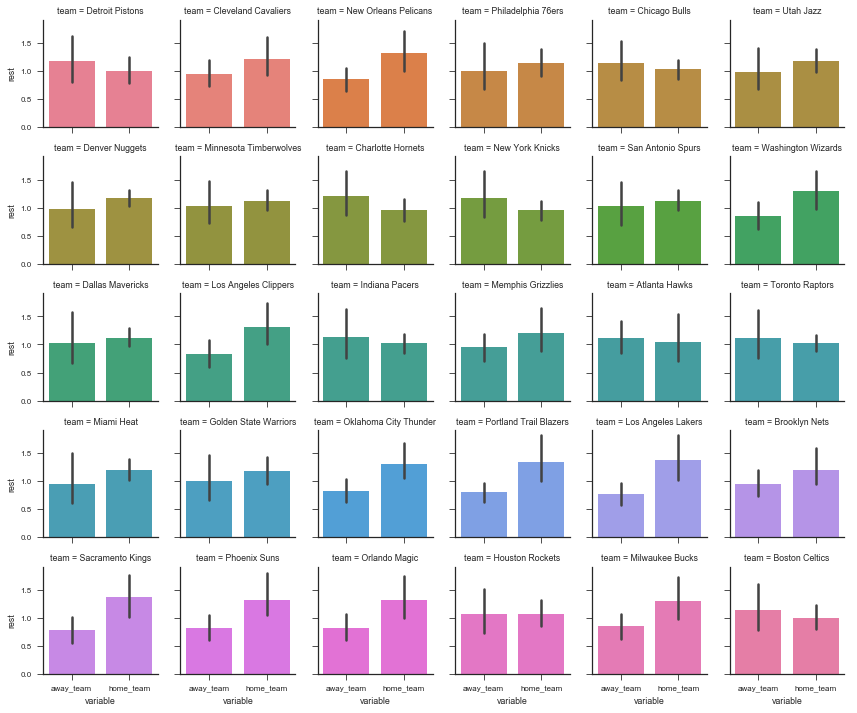

In [12]:
g = sns.FacetGrid(tidy, col='team', col_wrap=6, hue='team', size=2)
g.map(sns.barplot, 'variable', 'rest');

An example of a game-level statistic is the distribution of rest differences in games:

In [38]:
df['home_win'] = df['home_points'] > df['away_points']
df['rest_spread'] = df['home_rest'] - df['away_rest']
df.dropna().head()

,,away_team,away_points,home_team,home_points,away_rest,home_rest,home_win,rest_spread
game_id,date,,,,,,,,
17,2015-10-29,Memphis Grizzlies,112,Indiana Pacers,103,0.0,0.0,False,0.0
18,2015-10-29,Atlanta Hawks,112,New York Knicks,101,1.0,0.0,False,-1.0
19,2015-10-29,Dallas Mavericks,88,Los Angeles Clippers,104,0.0,0.0,True,0.0
20,2015-10-30,Miami Heat,92,Cleveland Cavaliers,102,1.0,1.0,True,0.0
21,2015-10-30,Utah Jazz,99,Philadelphia 76ers,71,1.0,1.0,False,0.0


In [45]:
delta.value_counts()

 0    13
-1     4
 1     3
 2     1
dtype: int64

In [48]:
delta.value_counts().reindex(np.arange(delta.min(), delta.max() + 1), fill_value=0)

-1     4
 0    13
 1     3
 2     1
dtype: int64

In [47]:
delta.value_counts().sort_index()

-1     4
 0    13
 1     3
 2     1
dtype: int64

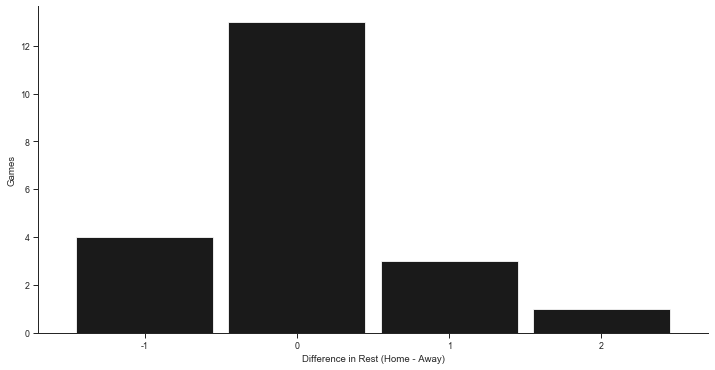

In [49]:
delta = (by_game.home_rest - by_game.away_rest).dropna().astype(int)
ax = (delta.value_counts()  # sort by descending count value
    .reindex(np.arange(delta.min(), delta.max() + 1), fill_value=0)
    .sort_index()
    .plot(kind='bar', color='k', width=.9, rot=0, figsize=(12, 6))
)
sns.despine()
ax.set(xlabel='Difference in Rest (Home - Away)', ylabel='Games');

Or the win percent by rest difference

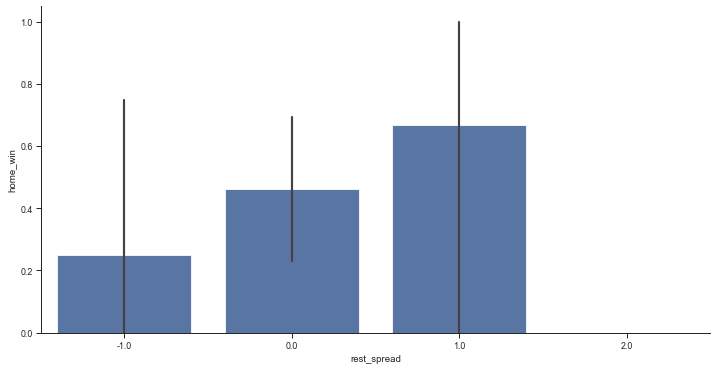

In [50]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x='rest_spread', y='home_win', data=df.query('-3 <= rest_spread <= 3'),
            color='#4c72b0', ax=ax)
sns.despine()

## Stack / Unstack

For MultiIndex (low cardinality), Pandas has two useful methods for quickly converting from wide to long format (`stack`) and long to wide (`unstack`).

In [51]:
rest = (tidy.groupby(['date', 'variable'])
            .rest.mean()
            .dropna())
rest.head()

date        variable 
2015-10-28  away_team    0.000000
            home_team    0.000000
2015-10-29  away_team    0.333333
            home_team    0.000000
2015-10-30  away_team    1.083333
Name: rest, dtype: float64

`rest` is in a "long" form since we have a single column of data, with multiple "columns" of metadata (in the MultiIndex). We use `.unstack` to move from long to wide.

In [52]:
rest.unstack().head()

variable,away_team,home_team
date,,
2015-10-28,0.000000,0.000000
2015-10-29,0.333333,0.000000
2015-10-30,1.083333,0.916667
2015-10-31,0.166667,0.833333


`unstack` moves a level of a MultiIndex (innermost by default) up to the columns.
`stack` is the inverse.

In [53]:
rest.unstack().stack()

date        variable 
2015-10-28  away_team    0.000000
            home_team    0.000000
2015-10-29  away_team    0.333333
            home_team    0.000000
2015-10-30  away_team    1.083333
            home_team    0.916667
2015-10-31  away_team    0.166667
            home_team    0.833333
dtype: float64

With `.unstack` you can move between those APIs that expect there data in long-format and those APIs that work with wide-format data. For example, `DataFrame.plot()`, works with wide-form data, one line per column.

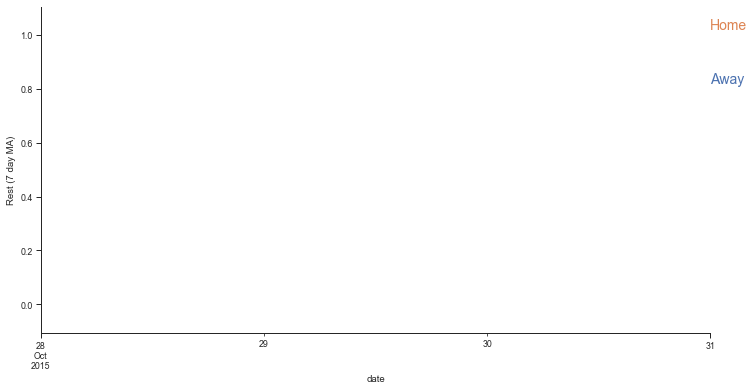

In [59]:
with sns.color_palette() as pal:
    b, g = pal.as_hex()[:2]

ax=(rest.unstack()
        .query('away_team < 7')
        .rolling(7)
        .mean()
        .plot(figsize=(12, 6), linewidth=3, legend=False))
ax.set(ylabel='Rest (7 day MA)')
ax.annotate("Home", (rest.index[-1][0], 1.02), color=g, size=14)
ax.annotate("Away", (rest.index[-1][0], 0.82), color=b, size=14)
sns.despine()

The most conenient form will depend on exactly what you're doing.
When interacting with databases you'll often deal with long form data.
Pandas' `DataFrame.plot` often expects wide-form data, while `seaborn` often expect long-form data. Regressions will expect wide-form data. Either way, it's good to be comfortable with `stack` and `unstack` (and MultiIndexes) to quickly move between the two.

## Mini Project: Home Court Advantage?

We've gone to all that work tidying our dataset, let's put it to use.
What's the effect (in terms of probability to win) of being
the home team?

### Step 1: Create an outcome variable

We need to create an indicator for whether the home team won.
Add it as a column called `home_win` in `games`.

In [20]:
df['home_win'] = df.home_points > df.away_points

### Step 2: Find the win percent for each team

In the 10-minute literature review I did on the topic, it seems like people include a team-strength variable in their regressions.
I suppose that makes sense; if stronger teams happened to play against weaker teams at home more often than away, it'd look like the home-effect is stronger than it actually is.
We'll do a terrible job of controlling for team strength by calculating each team's win percent and using that as a predictor.
It'd be better to use some kind of independent measure of team strength, but this will do for now.

We'll use a similar `melt` operation as earlier, only now with the `home_win` variable we just created.

In [83]:
df.head()

,,away_team,away_points,home_team,home_points,away_rest,home_rest,home_win,rest_spread
game_id,date,,,,,,,,
0,2015-10-27,Cleveland Cavaliers,95,Chicago Bulls,97,NaN,NaN,True,NaN
1,2015-10-27,Detroit Pistons,106,Atlanta Hawks,94,NaN,NaN,False,NaN
2,2015-10-27,New Orleans Pelicans,95,Golden State Warriors,111,NaN,NaN,True,NaN
3,2015-10-28,Washington Wizards,88,Orlando Magic,87,NaN,NaN,False,NaN
4,2015-10-28,Philadelphia 76ers,95,Boston Celtics,112,NaN,NaN,True,NaN


In [84]:
wins = (pd.melt(df.reset_index(), id_vars=["game_id", "date", "home_win"],
              value_vars=['away_team', 'home_team'], value_name='team', 
              var_name='is_home')
        .assign(win = lambda x: x.home_win == (x.is_home=='home_team'))
        .groupby(["team", "is_home"])
        .agg(
            n_win = ("win", "sum"),
            n_games = ("win", "count"),
            win_pct = ("win", "mean")
        )
       )

wins

n_win  n_games   win_pct
team               is_home                            
Atlanta Hawks      away_team    1.0        1  1.000000
                   home_team    1.0        2  0.500000
Boston Celtics     home_team    1.0        2  0.500000
Brooklyn Nets      away_team    0.0        2  0.000000
                   home_team    0.0        1  0.000000
...                             ...      ...       ...
Toronto Raptors    away_team    1.0        1  1.000000
                   home_team    1.0        1  1.000000
Utah Jazz          away_team    2.0        3  0.666667
Washington Wizards away_team    2.0        2  1.000000
                   home_team    0.0        1  0.000000

[52 rows x 3 columns]

In [91]:
wins = (
    pd.melt(df.reset_index(),
            id_vars=['game_id', 'date', 'home_win'],
            value_name='team', var_name='is_home',
            value_vars=['home_team', 'away_team'])
   .assign(win=lambda x: x.home_win == (x.is_home == 'home_team'))
   .groupby(['team', 'is_home'])
   .win
   .agg(['sum', 'count', 'mean'])
   .rename(columns=dict(sum='n_wins',
                        count='n_games',
                        mean='win_pct'))
)
wins.head()

n_wins  n_games  win_pct
team           is_home                            
Atlanta Hawks  away_team     1.0        1      1.0
               home_team     1.0        2      0.5
Boston Celtics home_team     1.0        2      0.5
Brooklyn Nets  away_team     0.0        2      0.0
               home_team     0.0        1      0.0

Pause for visualiztion, because why not

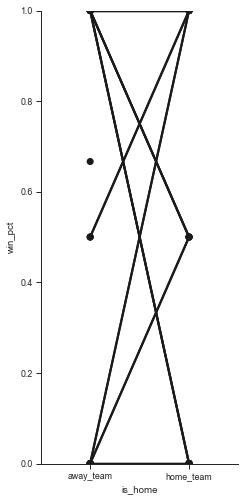

In [92]:
g = sns.FacetGrid(wins.reset_index(), hue='team', height=7, aspect=.5, palette=['k'])
g.map(sns.pointplot, 'is_home', 'win_pct', order=['away_team', 'home_team']).set(ylim=(0, 1));

(It'd be great if there was a library built on top of matplotlib that auto-labeled each point decently well. Apparently this is a difficult problem to do in general).

/Applications/anaconda3/envs/jupyterlab/lib/python3.7/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


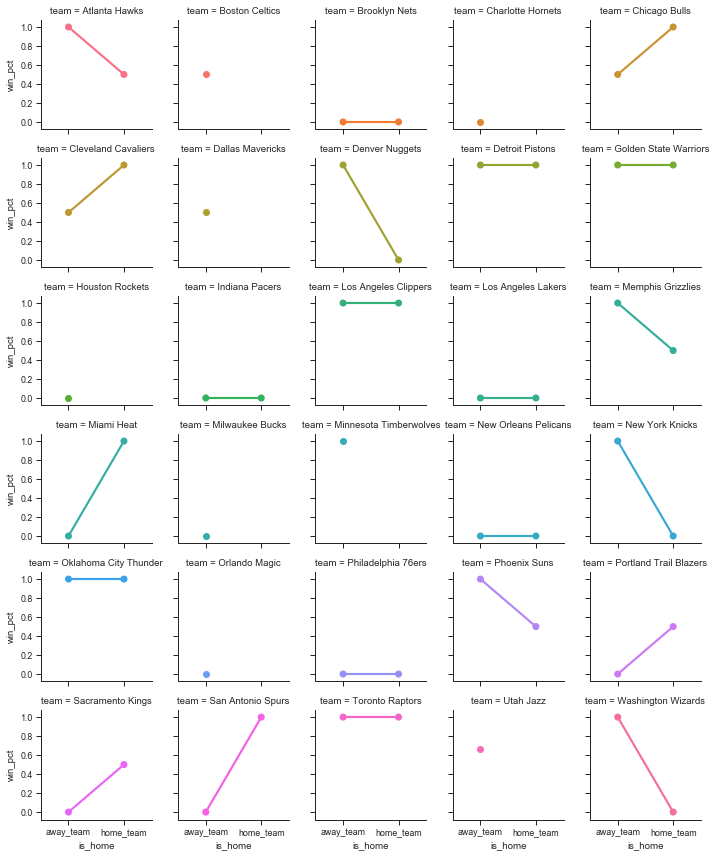

In [90]:
g = sns.FacetGrid(wins.reset_index(), col='team', hue='team', col_wrap=5, size=2)
g.map(sns.pointplot, 'is_home', 'win_pct')

Those two graphs show that most teams have a higher win-percent at home than away. So we can continue to investigate.
Let's aggregate over home / away to get an overall win percent per team.

In [98]:
win_percent = (
    # Use sum(games) / sum(games) instead of mean
    # since I don't know if teams play the same
    # number of games at home as away
    wins.groupby(level='team', as_index=True)
        .apply(lambda x: x.n_wins.sum() / x.n_games.sum())
)
win_percent.head()

team
Atlanta Hawks        0.666667
Boston Celtics       0.500000
Brooklyn Nets        0.000000
Charlotte Hornets    0.000000
Chicago Bulls        0.666667
dtype: float64

Text(0.5, 86.7, 'Win Percent')

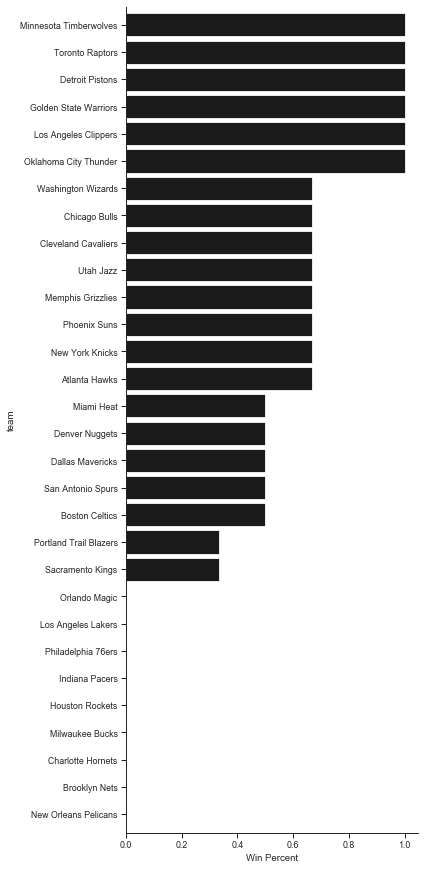

In [99]:
win_percent.sort_values().plot.barh(figsize=(6, 12), width=.85, color='k')
plt.tight_layout()
sns.despine()
plt.xlabel("Win Percent")

Is there a relationship between overall team strength and their home-court advantage?

In [103]:
wins.win_pct.unstack()

is_home,away_team,home_team
team,,
Atlanta Hawks,1.000000,0.5
Boston Celtics,NaN,0.5
Brooklyn Nets,0.000000,0.0
Charlotte Hornets,0.000000,NaN
Chicago Bulls,0.500000,1.0
...,...,...
Sacramento Kings,0.000000,0.5
San Antonio Spurs,0.000000,1.0
Toronto Raptors,1.000000,1.0


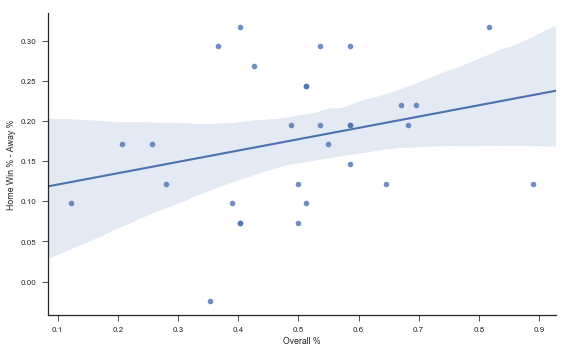

In [31]:
plt.figure(figsize=(8, 5))
(wins.win_pct
    .unstack()
    .assign(**{'Home Win % - Away %': lambda x: x.home_team - x.away_team,
               'Overall %': lambda x: (x.home_team + x.away_team) / 2})
     .pipe((sns.regplot, 'data'), x='Overall %', y='Home Win % - Away %')
)
sns.despine()
plt.tight_layout()

Let's get the team strength back into `df`.
You could you `pd.merge`, but I prefer `.map` when joining a `Series`.

In [110]:
win_percent

team
Atlanta Hawks         0.666667
Boston Celtics        0.500000
Brooklyn Nets         0.000000
Charlotte Hornets     0.000000
Chicago Bulls         0.666667
                        ...   
Sacramento Kings      0.333333
San Antonio Spurs     0.500000
Toronto Raptors       1.000000
Utah Jazz             0.666667
Washington Wizards    0.666667
Length: 30, dtype: float64

In [108]:
df['away_team']

game_id  date      
0        2015-10-27      Cleveland Cavaliers
1        2015-10-27          Detroit Pistons
2        2015-10-27     New Orleans Pelicans
3        2015-10-28       Washington Wizards
4        2015-10-28       Philadelphia 76ers
                               ...          
33       2015-10-31          New York Knicks
34       2015-10-31    Golden State Warriors
35       2015-10-31            Brooklyn Nets
36       2015-10-31             Phoenix Suns
37       2015-10-31         Sacramento Kings
Name: away_team, Length: 38, dtype: object

In [109]:
# if index matches existing value, replace existing value with new value
df['away_team'].map(win_percent)

game_id  date      
0        2015-10-27    0.666667
1        2015-10-27    1.000000
2        2015-10-27    0.000000
3        2015-10-28    0.666667
4        2015-10-28    0.000000
                         ...   
33       2015-10-31    0.666667
34       2015-10-31    1.000000
35       2015-10-31    0.000000
36       2015-10-31    0.666667
37       2015-10-31    0.333333
Name: away_team, Length: 38, dtype: float64

,team,away_strength
0,Atlanta Hawks,0.666667
1,Boston Celtics,0.500000
2,Brooklyn Nets,0.000000
3,Charlotte Hornets,0.000000
4,Chicago Bulls,0.666667
...,...,...
25,Sacramento Kings,0.333333
26,San Antonio Spurs,0.500000
27,Toronto Raptors,1.000000
28,Utah Jazz,0.666667


In [122]:
tmp1=pd.merge(df, win_percent.rename("away_strength", axis=1).reset_index(), left_on='away_team', right_on='team')
tmp2=pd.merge(tmp1, win_percent.rename("home_strength", axis=1).reset_index(), left_on='home_team', right_on='team')

In [32]:
df = df.assign(away_strength=df['away_team'].map(win_percent),
               home_strength=df['home_team'].map(win_percent),
               point_diff=df['home_points'] - df['away_points'],
               rest_diff=df['home_rest'] - df['away_rest'])
df.head()

,,away_team,away_points,home_team,home_points,away_rest,home_rest,home_win,rest_spread,away_strength,home_strength,point_diff,rest_diff
game_id,date,,,,,,,,,,,,
1,2015-10-27,Detroit Pistons,106.0,Atlanta Hawks,94.0,NaN,NaN,False,NaN,0.536585,0.585366,-12.0,NaN
2,2015-10-27,Cleveland Cavaliers,95.0,Chicago Bulls,97.0,NaN,NaN,True,NaN,0.695122,0.512195,2.0,NaN
3,2015-10-27,New Orleans Pelicans,95.0,Golden State Warriors,111.0,NaN,NaN,True,NaN,0.365854,0.890244,16.0,NaN
4,2015-10-28,Philadelphia 76ers,95.0,Boston Celtics,112.0,NaN,NaN,True,NaN,0.121951,0.585366,17.0,NaN
5,2015-10-28,Chicago Bulls,115.0,Brooklyn Nets,100.0,0.0,NaN,False,NaN,0.512195,0.256098,-15.0,NaN


In [33]:
import statsmodels.formula.api as sm

df['home_win'] = df.home_win.astype(int)  # for statsmodels

In [34]:
mod = sm.logit('home_win ~ home_strength + away_strength + home_rest + away_rest', df)
res = mod.fit()
res.summary()

Optimization terminated successfully.
         Current function value: 0.552792
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               home_win   No. Observations:                 1213
Model:                          Logit   Df Residuals:                     1208
Method:                           MLE   Df Model:                            4
Date:                Sun, 03 Sep 2017   Pseudo R-squ.:                  0.1832
Time:                        07:24:59   Log-Likelihood:                -670.54
converged:                       True   LL-Null:                       -820.91
                                        LLR p-value:                 7.479e-64
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.0707      0.314      0.225      0.822      -0.546       0.687
home_strength     5.4204      0.465     11.647      0.000       4.508       6.333
away_strength    -4.7445      0.452    -10.506      0.000      -5.630      -3.859
home_rest         0.0894      0.079      1.137      0.255      -0.065       0.243
away_rest        -0.0422      0.067     -0.629      0.529      -0.174       0.089
=================================================================================
"""

The strength variables both have large coefficeints (really we should be using some independent measure of team strength here, `win_percent` is showing up on the left and right side of the equation). The rest variables don't seem to matter as much.

With `.assign` we can quickly explore variations in formula.

In [35]:
(sm.Logit.from_formula('home_win ~ strength_diff + rest_spread',
                       df.assign(strength_diff=df.home_strength - df.away_strength))
    .fit().summary())

Optimization terminated successfully.
         Current function value: 0.553499
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               home_win   No. Observations:                 1213
Model:                          Logit   Df Residuals:                     1210
Method:                           MLE   Df Model:                            2
Date:                Sun, 03 Sep 2017   Pseudo R-squ.:                  0.1821
Time:                        07:25:00   Log-Likelihood:                -671.39
converged:                       True   LL-Null:                       -820.91
                                        LLR p-value:                 1.165e-65
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.4610      0.068      6.756      0.000       0.327       0.595
strength_diff     5.0671      0.349     14.521      0.000       4.383       5.751
rest_spread       0.0566      0.062      0.912      0.362      -0.065       0.178
=================================================================================
"""

In [36]:
mod = sm.Logit.from_formula('home_win ~ home_rest + away_rest', df)
res = mod.fit()
res.summary()

Optimization terminated successfully.
         Current function value: 0.676549
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               home_win   No. Observations:                 1213
Model:                          Logit   Df Residuals:                     1210
Method:                           MLE   Df Model:                            2
Date:                Sun, 03 Sep 2017   Pseudo R-squ.:               0.0003107
Time:                        07:25:00   Log-Likelihood:                -820.65
converged:                       True   LL-Null:                       -820.91
                                        LLR p-value:                    0.7749
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.3667      0.094      3.889      0.000       0.182       0.552
home_rest      0.0338      0.069      0.486      0.627      -0.102       0.170
away_rest     -0.0420      0.061     -0.693      0.488      -0.161       0.077
==============================================================================
"""

Overall not seeing to much support for rest mattering, but we got to see some more tidy data.

That's it for today.
Next time we'll look at data visualization.